In [117]:
import logging
import threading
from pathlib import Path
from typing import Any, List
import ee
import requests
from rasterio.crs import CRS
# from .abc import DownloadableABC
from typing import Tuple
log = logging.getLogger(__name__)
all = []
class DownloadableGEEImage():
    lock = threading.Lock()
    def getdownload_url(self,image: ee.Image,bands: List[str],region: ee.Geometry,crs: str,scale:int) -> Tuple[requests.Response, str]:
        """Get tile download url and response."""
        with self.lock:
            url = image.getDownloadURL(
                dict(format="GEO_TIFF", region=region, crs=crs, bands=bands, scale=scale)
            )
            return requests.get(url, stream=True), url
    def init(self, image: ee.Image):
        self.image = image
    def download(self,out: Path,region: ee.Geometry,crs: str,bands: List[str],scale:int,**kwargs: Any,) -> None:
        """Download a GEE Image in one go.
        It is up to the caller to make sure that the image does not exceed Google Earth Engine compute limit.
        Parameters
        ----------
        collection : ee.FeatureCollection
            The collection to download.
        out : Path
            Path to the geojson file to download the collection to.
        bands : list[str]
            Properties of the collection to select for download.
        region : ee.Geometry
            The ROI.
        crs : CRS
            The CRS to use for the features' geometries.
        """
        for key in kwargs.keys():
            log.warn(f"Argument {key} is ignored.")
        crs = crs#'EPSG:4326'#f"EPSG:{crs.to_epsg()}"
        scale = scale
        # get image download url and response
        image = self.image.reproject(crs= crs,scale=scale).clip(region)
        response, url = self.getdownload_url(image, bands, region, crs,scale)
        download_size = int(response.headers.get("content-length", 0))
        if download_size == 0 or not response.ok:
            resp_dict = response.json()
            if "error" in resp_dict and "message" in resp_dict["error"]:
                msg = resp_dict["error"]["message"]
                ex_msg = f"Error downloading tile: {msg}"
            else:
                ex_msg = str(response.json())
            raise IOError(ex_msg)
        with open(out, "wb") as geojsonfile:
            for data in response.iter_content(chunk_size=1024):
                geojsonfile.write(data)

import ee
ee.Authenticate()
# Initialize Earth Engine
ee.Initialize(project='ee-mrhuaize')

# Variables
years = [2019] #, 2020, 2021
county_names = ['Garfield']#, 'Adams', 'Harvey', 'Haskell', 'Minidoka', 'Jerome', 'Cassia'
state_names = ['Washington']#, 'North Dakota', 'Kansas', 'Texas', 'Idaho', 'Idaho', 'Idaho'
state_fips_codes = {'Washington': '53'} #, 'North Dakota': '38', 'Kansas': '20', 'Texas': '48', 'Idaho': '16'

# Load the TIGER/USCensus dataset
counties = ee.FeatureCollection("TIGER/2018/Counties")

def get_county(state, county):
    return counties.filter(ee.Filter.And(
        ee.Filter.eq('STATEFP', state),
        ee.Filter.eq('NAME', county)
    ))

def unique_values(collection, field):
    values = ee.Dictionary(collection.reduceColumns(ee.Reducer.frequencyHistogram(), [field]).get('histogram')).keys()
    return values

def daily_mosaics(imgs):
    def add_simple_time(img):
        d = ee.Date(img.get('system:time_start'))
        simple_date = ee.Date.fromYMD(d.get('year'), d.get('month'), d.get('day'))
        return img.set('simpleTime', simple_date.millis())

    imgs = imgs.map(add_simple_time)
    days = unique_values(imgs, 'simpleTime')

    def create_daily_mosaic(d):
        d = ee.Number.parse(d)
        d = ee.Date(d)
        t = imgs.filterDate(d, d.advance(1, 'day'))
        f = ee.Image(t.first())
        t = t.mosaic()
        t = t.set('system:time_start', d.millis())
        t = t.copyProperties(f)
        return t

    imgs = days.map(create_daily_mosaic)
    return ee.ImageCollection.fromImages(imgs)

def mask_s2_clouds(image):
    qa = image.select('QA60').int16()
    cloud_bit_mask = 1 << 10
    cirrus_bit_mask = 1 << 11
    mask = qa.bitwiseAnd(cloud_bit_mask).eq(0).And(qa.bitwiseAnd(cirrus_bit_mask).eq(0))
    return image.updateMask(mask)

def process_site(county, state, bound years, data_source,scale):
    county_feature = get_county(state, county)
    # bound = county_feature.geometry()
    for year in years:
        start_day = ee.Date.fromYMD(year, 1, 1)
        end_day = ee.Date.fromYMD(year + 1, 1, 1)

        if data_source == 'S2':
            collection = ee.ImageCollection("COPERNICUS/S2_SR") \
                .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 80)) \
                .filterBounds(bound) \
                .filterDate(start_day, end_day)
            collection = process_s2(collection, bound)
            band_names = ['blue', 'green', 'red', 'red1', 'red2', 'red3', 'nir', 'red4', 'swir1', 'swir2']
            scale = scale
            folder_name = f"{county}_S2_{year}"
        elif data_source == 'S1':
            collection = ee.ImageCollection("COPERNICUS/S1_GRD") \
                .filter(ee.Filter.eq('instrumentMode', 'IW')) \
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH')) \
                .filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING')) \
                .filterBounds(bound) \
                .filterDate(start_day, end_day)
            collection = process_s1(collection, bound)
            band_names = ['VV', 'VH']
            scale = scale
            folder_name = f"{county}_S1_{year}"
        elif data_source == 'MODIS':
            modis_collection = ee.ImageCollection("MODIS/061/MCD43A4")
            modis_vars = ['Nadir_Reflectance_Band1', 'Nadir_Reflectance_Band2', 'Nadir_Reflectance_Band3', 
                          'Nadir_Reflectance_Band4', 'Nadir_Reflectance_Band5', 'Nadir_Reflectance_Band6', 
                          'Nadir_Reflectance_Band7']
            for variable in modis_vars:
                data = modis_collection.filterBounds(bound).filterDate(start_day, end_day).select([variable])
                yearly_image = data.toBands().rename(data.aggregate_array('system:index')).clip(bound)
                yearly_image = yearly_image.set({
                    'year': year,
                    'region': county,
                    'variable': variable
                })
                
                export_image(yearly_image, f"{county}_{variable}_{year}", bound, scale, f"{county}_MODIS_{year}")
            return
        elif data_source == 'ERA5':
            era5_land = ee.ImageCollection("ECMWF/ERA5_LAND/DAILY_AGGR")
            era5_land_vars = ['temperature_2m', 'total_precipitation_sum', 'volumetric_soil_water_layer_1']
            for variable in era5_land_vars:
                data = era5_land.filterBounds(bound).filterDate(start_day, end_day).select([variable])
                yearly_image = data.toBands().rename(data.aggregate_array('system:index')).clip(bound)
                yearly_image = yearly_image.set({
                    'year': year,
                    'region': county,
                    'variable': variable
                })
                export_image(yearly_image, f"{county}_{variable}_{year}", bound, scale, f"{county}_ERA5_{year}")
            return

        data = collection.map(lambda img: img.select(band_names).addBands(img.select(['doy'])) \
            .set('system:index', img.get('system:index')))

        i_size = data.size().getInfo()
        data = data.toList(i_size)

        for i in range(i_size):
            worker(i, data, bound, county, year, scale, folder_name)

def process_s2(collection, bound):
    def process_image(img):
        t = img.select(['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12']).divide(10000)
        t = t.addBands(img.select(['QA60']))
        out = t.copyProperties(img).copyProperties(img, ['system:time_start'])
        return out

    collection = collection.map(process_image) \
        .select(['QA60', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12'], 
                ['QA60', 'aerosol', 'blue', 'green', 'red', 'red1', 'red2', 'red3', 'nir', 'red4', 'h2o', 'swir1', 'swir2']) \
        .map(lambda img: img.addBands(ee.Image.constant(ee.Date(img.get('system:time_start')).getRelative('day', 'year')).rename('doy').float()) \
            .set('doy', ee.Date(img.get('system:time_start')).getRelative('day', 'year'))) \
        .map(lambda img: img.clip(bound))

    collection = daily_mosaics(collection)
    collection = collection.map(mask_s2_clouds)

    return collection

def process_s1(collection, bound):
    return collection.select(['VV', 'VH']) \
        .map(lambda img: img.addBands(ee.Image.constant(ee.Date(img.get('system:time_start')).getRelative('day', 'year')).rename('doy').float()) \
            .set('doy', ee.Date(img.get('system:time_start')).getRelative('day', 'year'))) \
        .map(lambda img: img.clip(bound))

def worker(i, data, bound, county, year, scale, folder_name):
    format_name = f"{county}_{year}_{i + 1}"
    img = ee.Image(data.get(i))
    export_image(img, format_name, bound, scale, folder_name)

def export_image(img, description, region, scale, folder):
    downloader = DownloadableGEEImage()
    downloader.init(img)
    
    output_path = Path(folder) / f"{description}.tif"
    
    # 确保输出目录存在
    output_path.parent.mkdir(parents=True, exist_ok=True)
    
    # 获取图像的投影信息
    crs = 'EPSG:4326'
    # 获取图像的波段名称
    bands = img.bandNames().getInfo()
    
    # 下载图像
    downloader.download(out=output_path,region=region,crs=crs,bands=bands,scale=scale)
    
    print(f"Image downloaded to {output_path}")

# Process each site for each data source
data_sources = ['ERA5']#'S2', 'S1', , 'ERA5'
for county, state in zip(county_names, state_names):
    for data_source in data_sources:
        county_feature = get_county(state, county)
        bound = county_feature.geometry()
        process_site(county, state_fips_codes[state],bound years, data_source,scale=1000)

Image downloaded to Garfield_ERA5_2019/Garfield_temperature_2m_2019.tif
Image downloaded to Garfield_ERA5_2019/Garfield_total_precipitation_sum_2019.tif
Image downloaded to Garfield_ERA5_2019/Garfield_volumetric_soil_water_layer_1_2019.tif


In [118]:
county_feature = get_county(state, county)

In [121]:
def _get_download_url(
    self, collection: ee.FeatureCollection, format: Format
) -> Tuple[requests.Response, str]:
    """Get tile download url and response."""
    with self.lock:
        url = collection.getDownloadURL(filetype='kml')
        return requests.get(url, stream=True), url

NameError: name 'Format' is not defined

In [123]:
url = county_feature.getDownloadURL(filetype='kml')
requests.get(url, stream=True)

<Response [200]>

In [21]:
import xarray as xr
import rioxarray

In [107]:
data = xr.open_rasterio('/bess23/huaize/SITS-MoCo/preprocess/gee/Garfield_MODIS_2019/Garfield_Nadir_Reflectance_Band1_2019.tif')

/tmp/ipykernel_2593197/3222881832.py:1: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  data = xr.open_rasterio('/bess23/huaize/SITS-MoCo/preprocess/gee/Garfield_MODIS_2019/Garfield_Nadir_Reflectance_Band1_2019.tif')


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


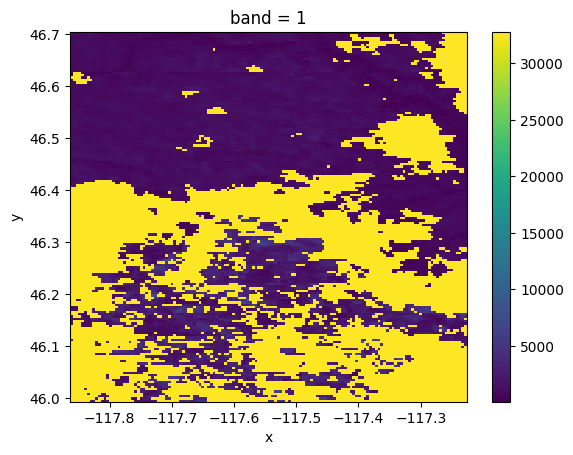

In [109]:
data.isel(band=0).plot.imshow()

In [ ]:
import ee
import geemap

# 初始化Earth Engine
ee.Initialize(project='ee-mrhuaize')
# Variables
years = [2019] #, 2020, 2021
county_names = ['Garfield']#, 'Adams', 'Harvey', 'Haskell', 'Minidoka', 'Jerome', 'Cassia'
state_names = ['Washington']#, 'North Dakota', 'Kansas', 'Texas', 'Idaho', 'Idaho', 'Idaho'
state_fips_codes = {'Washington': '53'} #, 'North Dakota': '38', 'Kansas': '20', 'Texas': '48', 'Idaho': '16'
# 导入矢量数据
vector =  get_county('Washington', 'Garfield')

# 获取边界并创建网格
bounds = vector.geometry().bounds()
proj = bounds.projection().crs()
utmBounds = bounds.transform(proj, 1)  # 1 meter precision

def createGrid(bounds, cellSize, overlap):
    coords = bounds.coordinates()
    xMin = ee.Number(coords.get(0)).get(0)
    yMin = ee.Number(coords.get(0)).get(1)
    xMax = ee.Number(coords.get(1)).get(0)
    yMax = ee.Number(coords.get(1)).get(1)
    
    width = xMax.subtract(xMin)
    height = yMax.subtract(yMin)
    
    cols = width.divide(cellSize.subtract(overlap)).ceil()
    rows = height.divide(cellSize.subtract(overlap)).ceil()
    
    def createCell(col):
        def inner(row):
            x = xMin.add(ee.Number(col).multiply(cellSize.subtract(overlap)))
            y = yMin.add(ee.Number(row).multiply(cellSize.subtract(overlap)))
            return ee.Feature(
                ee.Geometry.Rectangle([x, y, x.add(cellSize), y.add(cellSize)], proj)
            )
        return inner
    
    cells = ee.List.sequence(0, rows.subtract(1)).map(lambda row: 
        ee.List.sequence(0, cols.subtract(1)).map(createCell(row))
    ).flatten()
    
    return ee.FeatureCollection(cells)

cellSize = ee.Number(1000)  # in meters
overlap = ee.Number(100)  # in meters
grid = createGrid(utmBounds, cellSize, overlap)

# 遍历网格并处理
def processGrid(grid):
    clipped = vector.filterBounds(grid.geometry())
    
    # 在这里添加你的处理逻辑
    # 例如,计算面积:
    area = clipped.geometry().area()
    
    return grid.set('area', area)

processedGrid = grid.map(processGrid)

# 可视化结果
Map = geemap.Map()
Map.centerObject(vector)
Map.addLayer(vector, {'color': 'blue'}, 'Vector')
Map.addLayer(processedGrid, {'color': 'red'}, 'Grid')
Map

# 导出结果(如果需要)
task = ee.batch.Export.table.toDrive(
    collection=processedGrid,
    description='Processed_Grid',
    fileFormat='SHP'
)
task.start()

AttributeError: 'ComputedObject' object has no attribute 'get'